In [2]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
import xarray as xr
from tensorflow.keras import models, layers, regularizers,optimizers
# from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical
from scipy.io import savemat
# import h5py
import matplotlib.pyplot as plt
import pygmt
from sklearn.model_selection import train_test_split


# Generate the control and check sample
Save the data to files to be used in GGM methods (Matlab). Thus, the result could be compared with each other methods.

In [10]:
data = pygmt.select(region="-15/5/-4/4",data="../data/guinea.txt")
print(data.shape)
control, check = train_test_split(data, train_size=0.8, test_size=0.2, random_state=7)
control.to_csv('cont.txt',sep='\t',index=False)
check.to_csv('chec.txt',sep='\t',index=False)

(118280, 3)


In [2]:
data = pygmt.select(region="-15/5/-4/4",data="../data/guinea.txt")
# chose = data.sample(n=5000)
print(data.shape)
control, check = train_test_split(data, train_size=0.8, test_size=0.2, random_state=7)
# control = data.sample(frac=0.8)
print(control.shape)

print(check.shape)
check

(117814, 3)
(94251, 3)
(23563, 3)


,0,1,2
112181,-8.03471,3.94419,-2124.8
67530,-10.94000,-1.35600,-3584.0
6933,-13.39722,-3.57284,-3761.9
7781,0.83790,2.40659,-4665.0
109795,-13.62980,1.81790,-4394.0
...,...,...,...
57553,-2.98249,3.87481,-2583.0
47826,1.21720,1.51480,-4700.0
95971,2.88340,-3.36390,-4457.8
67097,-12.25200,0.82200,-4052.0


In [3]:
free = pygmt.grdcut(grid="../GeoModel/Free_Air_Gravity_Anomalies/Free_Air_Gravity_Anomalies.nc", region="-15.5/5.5/-4.5/4.5")
free_15s=pygmt.grdsample(grid=free,spacing="15s")



vgg = pygmt.grdcut(grid="../GeoModel/Vertical_Gravity_Gradient/Vertical_Gravity_Gradient.nc", region="-15.5/5.5/-4.5/4.5")
vgg_15s=pygmt.grdsample(grid=vgg,spacing="15s")

nvd = pygmt.grdcut(grid="../data/north_32.1.nc", region="-15.5/5.5/-4.5/4.5")
nvd_15s=pygmt.grdsample(grid=nvd,spacing="15s")

evd = pygmt.grdcut(grid="../data/east_32.1.nc", region="-15.5/5.5/-4.5/4.5")
evd_15s=pygmt.grdsample(grid=evd,spacing="15s")

In [4]:
con_lat_index=free_15s.indexes["lat"].get_indexer(control.values[:,1],method="nearest")
con_lon_index=free_15s.indexes["lon"].get_indexer(control.values[:,0],method="nearest")
con_lat_index

array([1254,  475,  443, ..., 1990, 2015, 2015])

In [5]:
shape = np.array([4,4,1])
x = 2
temp2 = []
for i in range(len(control[0])):

    free_temp = free_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    vgg_temp = vgg_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    nvd_temp = nvd_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    evd_temp = evd_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
#     mae_temp = mae_15s.isel(lat=slice(con_lat_index[i]-x,con_lat_index[i]+x),lon=slice(con_lon_index[i]-x,con_lon_index[i]+x))
    lat1 = free_15s.lat[con_lat_index[i]-x:con_lat_index[i]+x]
    lon1 = free_15s.lon[con_lon_index[i]-x:con_lon_index[i]+x]
    LAT,LON = np.meshgrid(lat1,lon1)
    # print(LON.shape)
    temp1 = np.concatenate([np.reshape(free_temp.values,shape),np.reshape(vgg_temp.values,shape),np.reshape(nvd_temp.values,shape),np.reshape(evd_temp.values,shape),np.reshape(LON,shape),np.reshape(LAT,shape)],axis=2)
    temp2.append(temp1)
temp2 = np.array(temp2)
temp2.shape

(94251, 4, 4, 6)

In [6]:
m,n,k,p = np.shape(temp2)
scalerlon = MinMaxScaler().fit(np.reshape(temp2[:,:,:,4],(m*n*k,1)))
scalerlat = MinMaxScaler().fit(np.reshape(temp2[:,:,:,5],(m*n*k,1)))
scalerfree = MinMaxScaler().fit(np.reshape(temp2[:,:,:,0],(m*n*k,1)))
scalervgg = MinMaxScaler().fit(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
scalernvd = MinMaxScaler().fit(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
scalerevd = MinMaxScaler().fit(np.reshape(temp2[:,:,:,3],(m*n*k,1)))
# scalermae = MinMaxScaler().fit(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
scalerdepth = MinMaxScaler().fit(np.reshape(control.values[:,2],(-1,1)))
lon_train = scalerlon.transform(np.reshape(temp2[:,:,:,4],(m*n*k,1)))
lat_train = scalerlat.transform(np.reshape(temp2[:,:,:,5],(m*n*k,1)))
free_train = scalerfree.transform(np.reshape(temp2[:,:,:,0],(m*n*k,1)))
vgg_train = scalervgg.transform(np.reshape(temp2[:,:,:,1],(m*n*k,1)))
nvd_train = scalernvd.transform(np.reshape(temp2[:,:,:,2],(m*n*k,1)))
evd_train = scalerevd.transform(np.reshape(temp2[:,:,:,3],(m*n*k,1)))
# mae_train = scalerevd.transform(np.reshape(temp2[:,:,:,6],(m*n*k,1)))
x_train = np.reshape(np.concatenate([free_train,vgg_train,nvd_train,evd_train,lon_train,lat_train],axis=1),(m,n,k,p))
y_train = scalerdepth.transform(np.reshape(control.values[:,2],(-1,1)))

# print(x_train[111,:,:,2])
print(x_train.shape)
print(y_train.shape)

(94251, 4, 4, 6)
(94251, 1)


In [7]:
# 打乱数据顺序
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape,y_train.shape)

(94251, 4, 4, 6) (94251, 1)


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), input_shape=(4,4, 6),activation='relu',padding="same", name="conv1",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3,3),activation='relu',padding="same", name="conv2",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Conv2D(256, (3,3),activation='relu',padding="same", name="conv3",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3),activation='relu',padding="same", name="conv5",data_format = 'channels_last'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1))

2022-10-02 08:21:15.019912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-02 08:21:15.819194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9024 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [9]:
opt = optimizers.Adam(learning_rate=0.001)
Patience = 3
early_stop = EarlyStopping(monitor='loss', mode='min', patience=Patience)
reduce_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.5, patience=Patience, mode='min',
                         min_delta=0.001, min_lr=1e-7, verbose=1)
model.compile(
        optimizer=opt,
        loss='mse',metrics='RootMeanSquaredError')
# tf.config.experimental_run_functions_eagerly(True)
model.fit(x_train, y_train, epochs=40
                    , batch_size=128
                    ,callbacks=reduce_lr)

Epoch 1/40


2022-10-02 08:21:18.211766: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


737/737 [==============================] - 9s 8ms/step - loss: 0.0806 - root_mean_squared_error: 0.2839 - lr: 0.0010
Epoch 2/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - lr: 0.0010
Epoch 3/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - lr: 0.0010
Epoch 4/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - lr: 0.0010
Epoch 5/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - lr: 0.0010
Epoch 6/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - lr: 0.0010
Epoch 7/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - lr: 0.0010
Epoch 8/40
737/737 [==============================] - 6s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 

In [24]:
che_lat_index=free_15s.indexes["lat"].get_indexer(check.values[:, 1],method="nearest")
che_lon_index=free_15s.indexes["lon"].get_indexer(check.values[:, 0],method="nearest")

In [25]:
temp_test = []
for i in range(len(check)):
    free_temp_test = free_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
    vgg_temp_test = vgg_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
    nvd_temp_test = nvd_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
    evd_temp_test = evd_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x))
#     mae_temp_test = mae_15s.isel(lat=slice(che_lat_index[i]-x,che_lat_index[i]+x,1),lon=slice(che_lon_index[i]-x,che_lon_index[i]+x,1))
    lat_temp_test = free_15s.lat[che_lat_index[i]-x:che_lat_index[i]+x]
    lon_temp_test = free_15s.lon[che_lon_index[i]-x:che_lon_index[i]+x]
    LAT_temp_test,LON_temp_test = np.meshgrid(lat_temp_test,lon_temp_test)
    # print(LON.shape)
    temp3 = np.concatenate([np.reshape(free_temp_test.values,shape),np.reshape(vgg_temp_test.values,shape),np.reshape(nvd_temp_test.values,shape),np.reshape(evd_temp_test.values,shape),np.reshape(LON_temp_test,shape),np.reshape(LAT_temp_test,shape)],axis=2)
    temp_test.append(temp3)
temp_test = np.array(temp_test)
temp_test.shape

(23563, 4, 4, 6)

In [26]:
mt,nt,kt,pt = np.shape(temp_test)
# scalerlon_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,4],(mt*nt*kt,1)))
# scalerlat_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,5],(mt*nt*kt,1)))
# scalerfree_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
# scalervgg_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
# scalernvd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# scalerevd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# scalerdepth_test = MinMaxScaler().fit(np.reshape(check.values[:,2],(-1,1)))
lon_test = scalerlon.transform(np.reshape(temp_test[:,:,:,4],(mt*nt*kt,1)))
lat_test = scalerlat.transform(np.reshape(temp_test[:,:,:,5],(mt*nt*kt,1)))
free_test = scalerfree.transform(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
vgg_test = scalervgg.transform(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
nvd_test = scalernvd.transform(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
evd_test = scalerevd.transform(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# mae_test = scalermae.transform(np.reshape(temp_test[:,:,:,6],(mt*nt*kt,1)))
x_test = np.reshape(np.concatenate([free_test,vgg_test,nvd_test,evd_test,lon_test,lat_test],axis=1),(mt,nt,kt,pt))
y_test = scalerdepth.transform(np.reshape(check.values[:,2],(-1,1)))
print(x_test.shape)
print(y_test.shape)

(23563, 4, 4, 6)
(23563, 1)


In [27]:
model.evaluate(x_test, y_test, batch_size=64)
model.save('../model/Africa_cnn7.h5')
pre = model.predict(x_test, batch_size=64)
pre_raw = scalerdepth.inverse_transform(pre)

369/369 [==============================] - 1s 3ms/step


## pre_data

In [17]:
%%time
temp_pre = []
# lonlat=[]
free_all = np.array(free_15s.data,dtype=float)

vgg_all = np.array(vgg_15s.data,dtype=float)
evd_all = np.array(evd_15s.data,dtype=float)
nvd_all = np.array(nvd_15s.data,dtype=float)
lat_all = np.array(free_15s.lat.data,dtype=float)
lon_all = np.array(free_15s.lon.data,dtype=float)
for i in np.arange(2,len(lat_all),4):
    for j in np.arange(2,len(lon_all),4):
        free_temp_pre = free_all[i-x:i+x,j-x:j+x]
        vgg_temp_pre = vgg_all[i-x:i+x,j-x:j+x]
        nvd_temp_pre = nvd_all[i-x:i+x,j-x:j+x]
        evd_temp_pre = evd_all[i-x:i+x,j-x:j+x]
        lat_temp_pre = lat_all[i-x:i+x]
        lon_temp_pre = lon_all[j-x:j+x]
        LAT_temp_pre,LON_temp_pre = np.meshgrid(lat_temp_pre,lon_temp_pre)
        # print(LON.shape)
        temp4 = np.concatenate([np.reshape(free_temp_pre,shape),np.reshape(vgg_temp_pre,shape),np.reshape(nvd_temp_pre,shape),np.reshape(evd_temp_pre,shape),np.reshape(LON_temp_pre,shape),np.reshape(LAT_temp_pre,shape)],axis=2)
#         lonlat.append(np.concatenate((lat_temp_pre,lon_temp_pre),axis=1))
        temp_pre.append(temp4)
temp_pre = np.array(temp_pre,dtype=float)

CPU times: user 39.8 s, sys: 974 ms, total: 40.8 s
Wall time: 40.7 s


In [18]:
np.save("pre_cnn_free.npy",temp_pre)

In [19]:
a,b,c,d = np.shape(temp_pre)
# scalerlon_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,4],(mt*nt*kt,1)))
# scalerlat_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,5],(mt*nt*kt,1)))
# scalerfree_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,0],(mt*nt*kt,1)))
# scalervgg_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,1],(mt*nt*kt,1)))
# scalernvd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,2],(mt*nt*kt,1)))
# scalerevd_test = MinMaxScaler().fit(np.reshape(temp_test[:,:,:,3],(mt*nt*kt,1)))
# scalerdepth_test = MinMaxScaler().fit(np.reshape(check.values[:,2],(-1,1)))
lon_pre = scalerlon.transform(np.reshape(temp_pre[:,:,:,4],(a*b*c,1)))
lat_pre = scalerlat.transform(np.reshape(temp_pre[:,:,:,5],(a*b*c,1)))
free_pre = scalerfree.transform(np.reshape(temp_pre[:,:,:,0],(a*b*c,1)))
vgg_pre = scalervgg.transform(np.reshape(temp_pre[:,:,:,1],(a*b*c,1)))
nvd_pre = scalernvd.transform(np.reshape(temp_pre[:,:,:,2],(a*b*c,1)))
evd_pre = scalerevd.transform(np.reshape(temp_pre[:,:,:,3],(a*b*c,1)))
# mae_test = scalermae.transform(np.reshape(temp_test[:,:,:,6],(mt*nt*kt,1)))
x_pre = np.reshape(np.concatenate([free_pre,vgg_pre,nvd_pre,evd_pre,lon_pre,lat_pre],axis=1),(a,b,c,d))


In [20]:
pre_depth = model.predict(x_pre,batch_size=120)
grid_depth = scalerdepth.inverse_transform(pre_depth)


5670/5670 [==============================] - 18s 3ms/step


In [21]:
lat_grid = []
lon_grid = []
for i in np.arange(2,len(free_15s.lat),4):
    for j in np.arange(2,len(free_15s.lon),4):
        lat_grid.append(lat_all[i])
        lon_grid.append(lon_all[j])
lat_huatu = np.array(lat_grid)
lon_huatu = np.array(lon_grid)

depth_cnn=np.concatenate((np.reshape(lon_huatu,(-1,1)),np.reshape(lat_huatu,(-1,1)), grid_depth), axis=1)

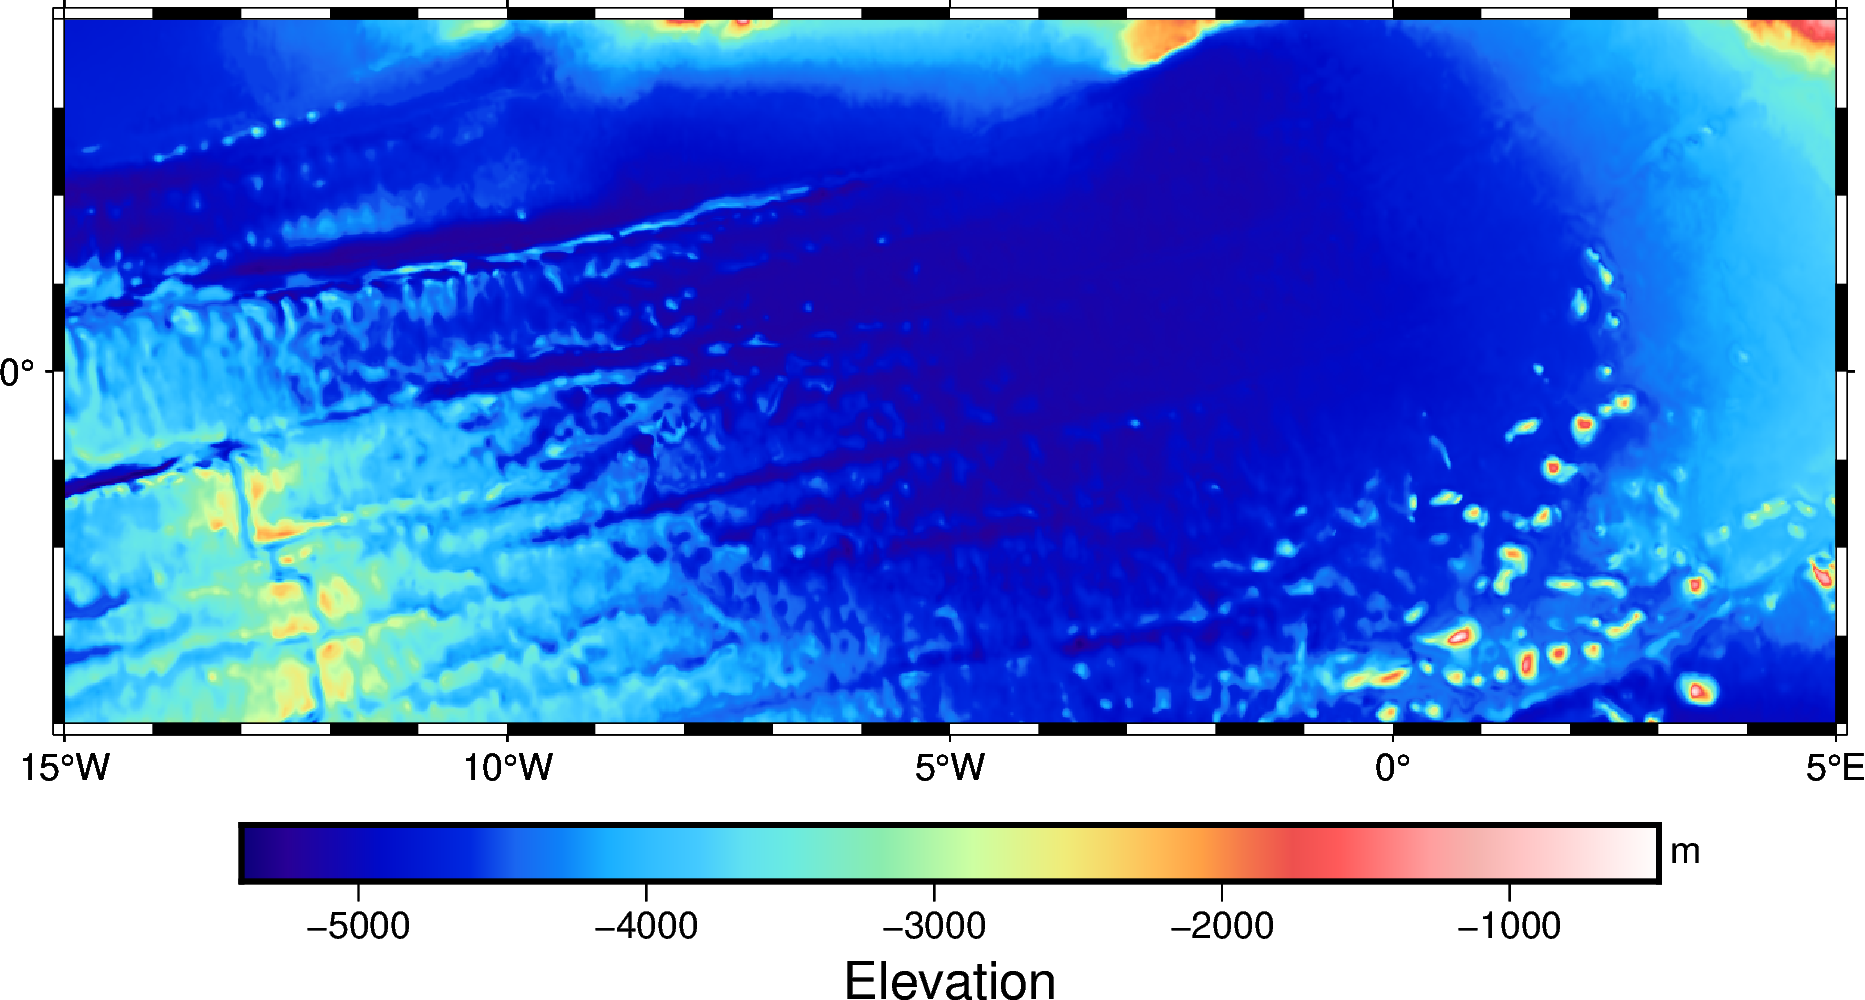

In [22]:
fig = pygmt.Figure()
pygmt.surface(region="-15/5/-4/4", spacing="1m",outgrid="depth_cnn.grd",data=depth_cnn)
fig.basemap(region="-15/5/-4/4", projection="M15c", frame="afg")
fig.coast(borders=["1/0.5p,black", "2/0.5p,red", "3/0.5p,blue"], land="gray")
fig.grdimage(
    grid="depth_cnn.grd",
    cmap="haxby",
    frame=True,
)
fig.colorbar(frame=["a", "x+lElevation", "y+lm"])

fig.show(width="1000")


In [23]:
depth_case = xr.open_dataset("depth_cnn.grd")
depth_case.to_netcdf("../result/depth_case7.nc")